# Sentiment Analysis

In this notebook, we will investigate the sentiment visible in politicians' tweets. We will perform two methods: a lexicon-based approach using VADER [1] and a supervised approach using the most recent version of the RoBERTa-base model [2].

## 1. Libraries

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import tqdm
import torch

from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
from wordcloud import WordCloud

## 2. Reading data

In [18]:
df = pd.read_parquet('../data/03.cleaned/df_combined.parquet')
nltk.download('vader_lexicon')
df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mateuszpliszka/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,reply_settings,created_at,attachments,edit_controls,author_id,edit_history_tweet_ids,lang,possibly_sensitive,id,conversation_id,...,reply_count,like_count,quote_count,impression_count,text_clean_en,text_clean_en_demojized,text_clean_demojized,emoji_count_en,emoji_count,name
0,everyone,2024-10-15 07:13:34+00:00,"{'media_keys': ['3_1846083966849159168', '3_1846083985216008192', '3_1846084014731362304'], 'media_source_tweet_id': None, 'poll_ids': None}","{'editable_until': '2024-10-15 08:12:39+00:00', 'edits_remaining': 4, 'is_edit_eligible': True}",1.284852e+18,"[1846086770229694583, 1846086999964283214]",pl,False,1846086999964283136,1.846087e+18,...,61,644,7,11648,"❌ The Polish government intends to build 49 Foreigners Integration Centers in Poland as a remedy for migrants, of whom there may be as many as 250,000 in Poland. – not to mention the thousands that Poland will accept in the coming years. And if someone says they won't accept it, they're LYING. ➡️…",":cross_mark: The Polish government intends to build 49 Foreigners Integration Centers in Poland as a remedy for migrants, of whom there may be as many as 250,000 in Poland. – not to mention the thousands that Poland will accept in the coming years. And if someone says they won't accept it, they're LYING. :right_arrow:…",":cross_mark: Rząd polski zamierza budować w Polsce 49 Centrów Integracji Cudzoziemców jako remedium na migrantów, których w Polsce może być już nawet 250 tys. – nie mówiąc o tysiącach, których Polska przyjmie w najbliższych latach. A jeśli ktoś twierdzi, że nie przyjmie – to KŁAMIE.\n :right_arrow: …",2,3,Grzegorz Płaczek
1,everyone,2024-10-14 08:46:51+00:00,None,"{'editable_until': '2024-10-14 09:43:52+00:00', 'edits_remaining': 4, 'is_edit_eligible': True}",1.284852e+18,"[1845747336862961872, 1845748090461966651]",pl,False,1845748090461966592,1.845748e+18,...,169,3845,57,146584,"❌ The cesspool is breaking out and it's getting more and more interesting. More and more new facts are coming to light. Well, the guidelines for the operation of 49 Foreigners Integration Centers (CIC) provide for foreigners throughout Poland, among others... the employment of PERSONAL ASSISTANTS in offices,...",":cross_mark: The cesspool is breaking out and it's getting more and more interesting. More and more new facts are coming to light. Well, the guidelines for the operation of 49 Foreigners Integration Centers (CIC) provide for foreigners throughout Poland, among others... the employment of PERSONAL ASSISTANTS in offices,...",":cross_mark: Szambo wybija i robi się coraz ciekawiej. Na światło dzienne wychodzą bowiem coraz to nowe fakty. Otóż wytyczne funkcjonowania 49 Centrów Integracji Cudzoziemców (CIC) przewidują dla cudzoziemców w całej Polsce między innymi… zatrudnianie OSOBISTYCH ASYSTENTÓW w urzędach,…",1,1,Grzegorz Płaczek
2,everyone,2024-10-13 07:30:58+00:00,None,"{'editable_until': '2024-10-13 08:30:58+00:00', 'edits_remaining': 5, 'is_edit_eligible': True}",1.284852e+18,[1845366606823657982],pl,False,1845366606823657984,1.845367e+18,...,145,2061,28,100757,"❌ I DON'T UNDERSTAND HOW YOU CAN HURT YOUR OWN NATION IN THIS WAY?! Dark times are coming for Poles. For years. And perhaps even longer than we think. The Honorable Prime Minister, opening the #RadaKrajowaKO party convention in Warsaw, announced a PROGRAM that is dangerous for Poles...",":cross_mark: I DON'T UNDERSTAND HOW YOU CAN HURT YOUR OWN NATION IN THIS WAY?! Dark times are coming for Poles. For years. And perhaps even longer than we think. The Honorable Prime Minister, opening the #RadaKrajowaKO party convention in Warsaw, announced a PROGRAM that is dangerous for Poles...",":cross_mark: NIE ROZUMIEM, JAK MOŻNA KRZYWDZIĆ W TEN SPOSÓB WŁASNY NARÓD?! Nadchodzą ciemne czasy dla Polaków. Na lata. A być może nawet na dłużej, niż myślimy. Szanowny Pan Premier , otwierając konwencję partyjną w Warszawie #RadaKrajowaKO, ogłosił groźny dla Polaków, PROGRAM…",1,1,Grzegorz Płaczek
3,everyone,2024-10-12 07:38:50+00

## 3. Lexicon based Sentiment Analysis (VADER)

In [19]:
sia = SentimentIntensityAnalyzer()
res = {}

for i, row in tqdm.tqdm(df.iterrows(), total=len(df)):
    text = row['text_clean_en_demojized']
    myID = row['id']
    res[myID] = sia.polarity_scores(text)

vader_res = pd.DataFrame.from_dict(res, orient='index').reset_index()
vader_res.rename(columns={'index': 'id', 'neg': 'neg_vader', 'neu': 'neu_vader', 'pos': 'pos_vader', 'compound': 'compound_vader'}, inplace=True)
print("Average sentiment scores:")
print(vader_res.iloc[:, 1:5].mean())
df_no_na = df.merge(vader_res, on='id', how='left')
df_no_na[["username", "name", "text_clean_en", "neg_vader", "neu_vader", "pos_vader", "compound_vader"]].head()

100%|██████████| 48331/48331 [00:11<00:00, 4031.27it/s]


Average sentiment scores:
neg_vader         0.064897
neu_vader         0.783345
pos_vader         0.151343
compound_vader    0.164220
dtype: float64


,username,name,text_clean_en,neg_vader,neu_vader,pos_vader,compound_vader
0,placzekgrzegorz,Grzegorz Płaczek,"❌ The Polish government intends to build 49 Foreigners Integration Centers in Poland as a remedy for migrants, of whom there may be as many as 250,000 in Poland. – not to mention the thousands that Poland will accept in the coming years. And if someone says they won't accept it, they're LYING. ➡️…",0.071,0.840,0.089,0.0173
1,placzekgrzegorz,Grzegorz Płaczek,"❌ The cesspool is breaking out and it's getting more and more interesting. More and more new facts are coming to light. Well, the guidelines for the operation of 49 Foreigners Integration Centers (CIC) provide for foreigners throughout Poland, among others... the employment of PERSONAL ASSISTANTS in offices,...",0.000,0.896,0.104,0.6549
2,placzekgrzegorz,Grzegorz Płaczek,"❌ I DON'T UNDERSTAND HOW YOU CAN HURT YOUR OWN NATION IN THIS WAY?! Dark times are coming for Poles. For years. And perhaps even longer than we think. The Honorable Prime Minister, opening the #RadaKrajowaKO party convention in Warsaw, announced a PROGRAM that is dangerous for Poles...",0.155,0.734,0.111,-0.3453
3,placzekgrzegorz,Grzegorz Płaczek,"🆘 The pharmaceutical company GSK will pay over $2 billion in compensation for a drug that, instead of treating heartburn, increased the risk of cancer! ➡️ Greetings to all big pharma lobbyists, ""sellout"" experts and scientists and corrupt politicians. Greetings also...",0.164,0.681,0.154,-0.1260
4,placzekgrzegorz,Grzegorz Płaczek,"❌ WHAT IS GOING ON HERE? In October 2024, her boss, the Minister of Health, announced that the National Health Fund needed approximately PLN 3 billion from the state budget to pay hospitals for the next quarter of overperformance, adding that ""THIS MONEY DOES NOT EXIST"", while... ➡️…",0.030,0.970,0.000,-0.1027


In [21]:
df_for_bert = df_no_na.copy()

### 3.1. Top 5 most negative politicians

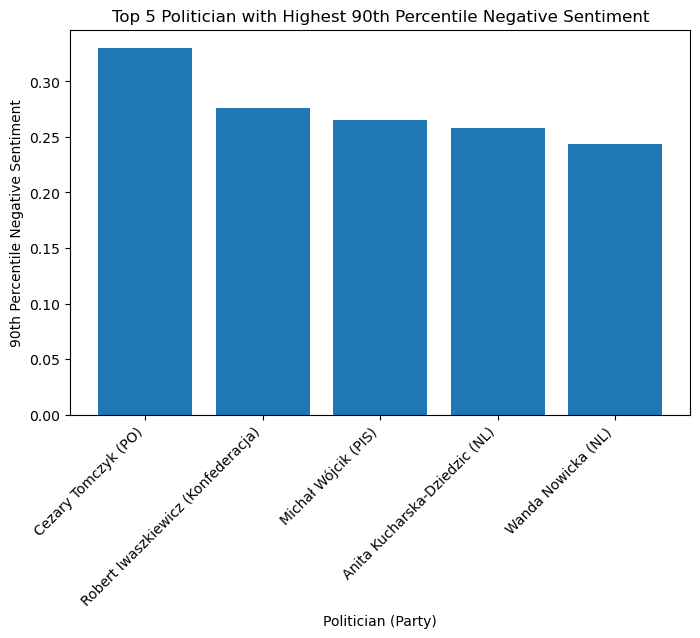

In [20]:
percentile_90_neg = df_no_na.groupby('username')['neg_vader'].quantile(0.90).reset_index()

top5_neg_sentiment = percentile_90_neg.sort_values(by='neg_vader', ascending=False).head(5)
top5_neg_sentiment = top5_neg_sentiment.merge(df[['username', 'name', 'party']].drop_duplicates(), on='username', how='left')

plt.figure(figsize=(8, 5))
top5_neg_sentiment['name_with_party'] = top5_neg_sentiment['name'].apply(
    lambda name: f"{name} ({df[df['name'] == name]['party'].iloc[0]})"
)
bars = plt.bar(top5_neg_sentiment['name_with_party'], top5_neg_sentiment["neg_vader"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Top 5 Politician with Highest 90th Percentile Negative Sentiment')
plt.xlabel('Politician (Party)')
plt.ylabel('90th Percentile Negative Sentiment')
plt.show()

According to the VADER analysis, the top 5 politicians with the highest 90th percentile of negative sentiment in their tweets represent almost all parties except PL2050, with two individuals from Nowa Lewica included.

### 3.2. Top 5 most positive politicians

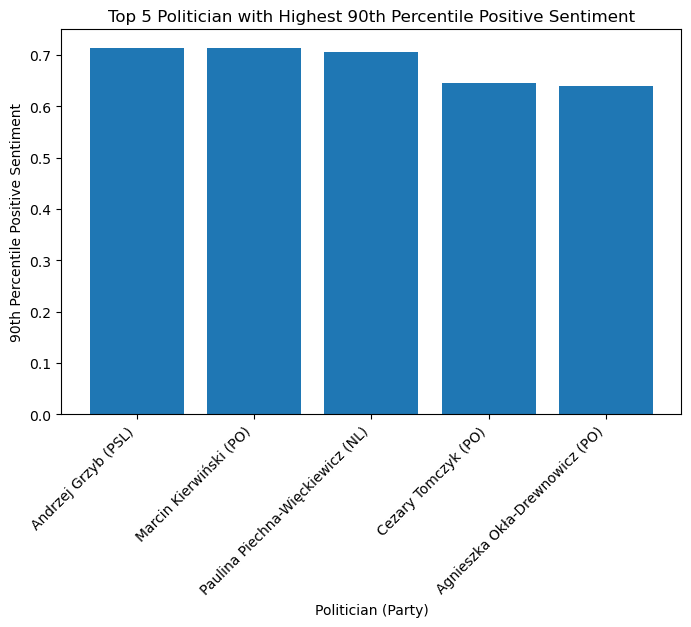

In [5]:
percentile_90_pos = df_no_na.groupby('username')['pos_vader'].quantile(0.90).reset_index()

top5_pos_sentiment = percentile_90_pos.sort_values(by='pos_vader', ascending=False).head(5)
top5_pos_sentiment = top5_pos_sentiment.merge(df[['username', 'name', 'party']].drop_duplicates(), on='username', how='left')

plt.figure(figsize=(8, 5))
top5_pos_sentiment['name_with_party'] = top5_pos_sentiment['name'].apply(
    lambda name: f"{name} ({df[df['name'] == name]['party'].iloc[0]})"
)
bars = plt.bar(top5_pos_sentiment['name_with_party'], top5_pos_sentiment["pos_vader"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Top 5 Politician with Highest 90th Percentile Positive Sentiment')
plt.xlabel('Politician (Party)')
plt.ylabel('90th Percentile Positive Sentiment')
plt.show()

According to the VADER analysis, the top 5 politicians with the highest 90th percentile of positive sentiment in their tweets include 3 individuals from PO, 1 from PSL, and 1 from NL.

### 3.3. Negative Sentiment on party level

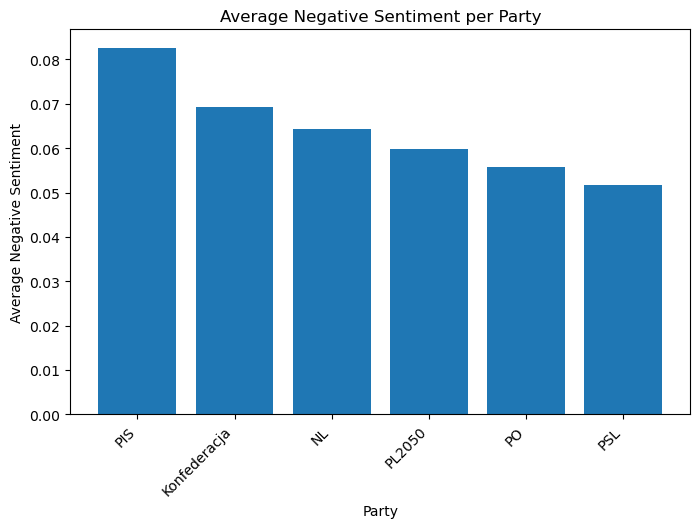

In [6]:
average_neg_sentiment_party = df_no_na.groupby('party')['neg_vader'].mean().reset_index()

top5_avg_neg_sentiment_party = average_neg_sentiment_party.sort_values(by='neg_vader', ascending=False)

plt.figure(figsize=(8, 5))
bars = plt.bar(top5_avg_neg_sentiment_party['party'], top5_avg_neg_sentiment_party["neg_vader"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Average Negative Sentiment per Party')
plt.xlabel('Party')
plt.ylabel('Average Negative Sentiment')
plt.show()


We can observe that the plot shows the highest average negative sentiment for PIS, followed closely by Konfederacja. The lowest average negative sentiment is observed for PO and PSL.

### 3.4. Positive Sentiment on party level

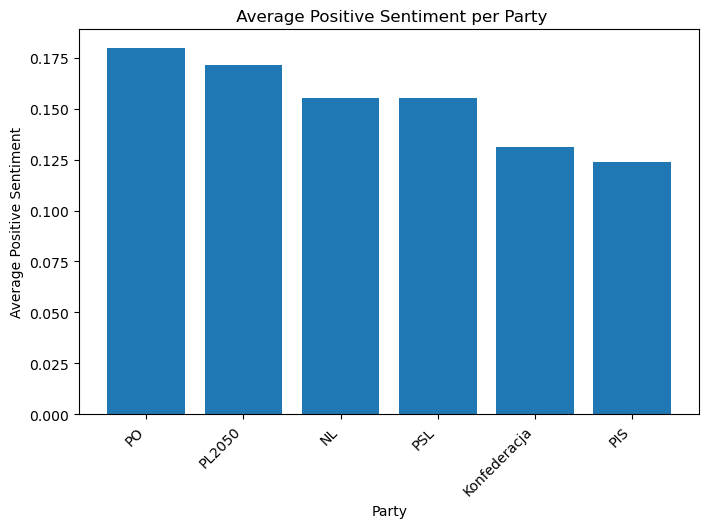

In [7]:
average_pos_sentiment_party = df_no_na.groupby('party')['pos_vader'].mean().reset_index()

top5_avg_pos_sentiment_party = average_pos_sentiment_party.sort_values(by='pos_vader', ascending=False)

plt.figure(figsize=(8, 5))
bars = plt.bar(top5_avg_pos_sentiment_party['party'], top5_avg_pos_sentiment_party["pos_vader"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title(' Average Positive Sentiment per Party')
plt.xlabel('Party')
plt.ylabel('Average Positive Sentiment')
plt.show()


We can observe that the plot is a rotated version of the previous plot. The highest average positive sentiment is for PO, PL2050, NL, and PSL, while Konfederacja, and PIS have lower scores.

### 3.5. Most Negative Tweets 

In [8]:
top_5_negative_tweets = df_no_na.nlargest(10, 'neg_vader')[['name', 'party', 'text_clean_en', 'neg_vader']]
print("Top 5 Most Negative Tweets:")
print(top_5_negative_tweets)

Top 5 Most Negative Tweets:
                   name         party text_clean_en  neg_vader
53     Grzegorz Płaczek  Konfederacja     Disgrace!        1.0
180    Grzegorz Płaczek  Konfederacja          - NO        1.0
576        Michał Wawer  Konfederacja            NO        1.0
746        Michał Wawer  Konfederacja            NO        1.0
1115   Konrad Berkowicz  Konfederacja    Criminals.        1.0
7150  Witold Tumanowicz  Konfederacja           NO.        1.0
7155  Witold Tumanowicz  Konfederacja           NO.        1.0
8230  Witold Tumanowicz  Konfederacja           NO.        1.0
9113   Marek Sypniewski  Konfederacja            NO        1.0
9291    Krzysztof Tuduj  Konfederacja          Sad.        1.0


In [9]:
pd.set_option('display.max_colwidth', None)
df_no_na['word_count'] = df_no_na['text_clean_en'].apply(lambda x: len(str(x).split()))
df_no_na = df_no_na[df_no_na['word_count'] >= 3]
top_negative_posts = df_no_na.nlargest(10, 'neg_vader')[['name', 'party', 'text_clean_en', 'neg_vader']]
print("Top 5 Most Negative Tweets (longer than 2 words):")
print(top_negative_posts)

Top 5 Most Negative Tweets (longer than 2 words):
                             name         party                 text_clean_en  \
44589                  Paweł Śliz        PL2050      Terribly weak. Terrible.   
16596              Marcin Kulasek            NL             No more war!  🇵 🇱   
34079            Dorota Niedziela            PO    Shamelessness and villainy   
43068       Paulina Hennig-Kloska        PL2050         Sad and embarrassing.   
6989             Konrad Berkowicz  Konfederacja          PiS, PO - one evil!    
10762          Włodzimierz Skalik  Konfederacja          PiS, PO - one evil.    
39699                  Paweł Śliz        PL2050          Sarcasm was sarcasm.   
14580               Wanda Nowicka            NL              What a bastard!    
19024  Małgorzata Moskwa-Wodnicka            NL                 Quite a bomb!   
35700            Dorota Niedziela            PO  Liars, liars, liars... #PIS    

       neg_vader  
44589      1.000  
16596      0.870  
3

We can observe that VADER was able to capture negative tweets. However, they were not as negative as expected. Without filtering the shortest tweets, the most negative tweets were simply "NO." After filtering to consider tweets longer than two words, the tweets were still not very negative or offensive.

### 3.6. Most Positive Tweets 

In [10]:
top_5_positive_tweets = df_no_na.nlargest(10, 'pos_vader')[['name', 'party', 'text_clean_en', 'pos_vader']]
print("Top 5 Most Positive Tweets:")
print(top_5_positive_tweets)

Top 5 Most Positive Tweets:
                              name         party                text_clean_en  \
3670              Sławomir Mentzen  Konfederacja  Congratulations! Good luck!   
6741              Marek Sypniewski  Konfederacja                  Good luck !   
18247            Krzysztof Śmiszek            NL       Great! Welcome aboard!   
18804            Beata Maciejewska            NL                  I invite :)   
19131   Małgorzata Moskwa-Wodnicka            NL         Happy!!! 🇵 🇱 🇵 🇱 🇵 🇱   
21138            Krzysztof Śmiszek            NL   Welcome aboard! Good luck!   
21510            Krzysztof Śmiszek            NL         Well, cool, cool :-)   
22083  Paulina Piechna-Więckiewicz            NL                   I invite !   
41380                 Maciej Żywno        PL2050                good, good :)   
43792                 Maciej Żywno        PL2050              I invite :)       

       pos_vader  
3670         1.0  
6741         1.0  
18247        1.0  
1880

In [11]:
pd.set_option('display.max_colwidth', None)
df_no_na = df_no_na[df_no_na['word_count'] >= 10]
top_positive_posts = df_no_na.nlargest(10, 'pos_vader')[['name', 'party', 'text_clean_en', 'pos_vader']]
print("Top 5 Most Positive Tweets (longer than 9 words):")
print(top_positive_posts)

Top 5 Most Positive Tweets (longer than 9 words):
                            name         party  \
34128           Dorota Niedziela            PO   
46473           Stefan Krajewski           PSL   
16451      Włodzimierz Czarzasty            NL   
3283            Sławomir Mentzen  Konfederacja   
6333            Marek Sypniewski  Konfederacja   
34045           Dorota Niedziela            PO   
39089  Małgorzata Kidawa-Błońska            PO   
5028             Bartłomiej Pejo  Konfederacja   
22987   Anita Kucharska-Dziedzic            NL   
41296               Maciej Żywno        PL2050   

                                                                                                           text_clean_en  \
34128                                                         Celebrating 🇵 🇱 🇵 🇱 🇵 🇱 🇵 🇱 #DzieńaflagiRP 🇵 🇱 🇵 🇱 🇵 🇱 🇵 🇱   
46473                                                                    Dear Ladies, please accept my best wishes 🌹 🌹 🌹   
16451             #EuropeFo

VADER effectively captured positive tweets. Unlike negative tweets, unfiltered positive tweets are meaningful and often congratulatory. Tweets longer than 9 words are also related to celebrations, congratulations, and positive events.

### 3.7. Wordclouds

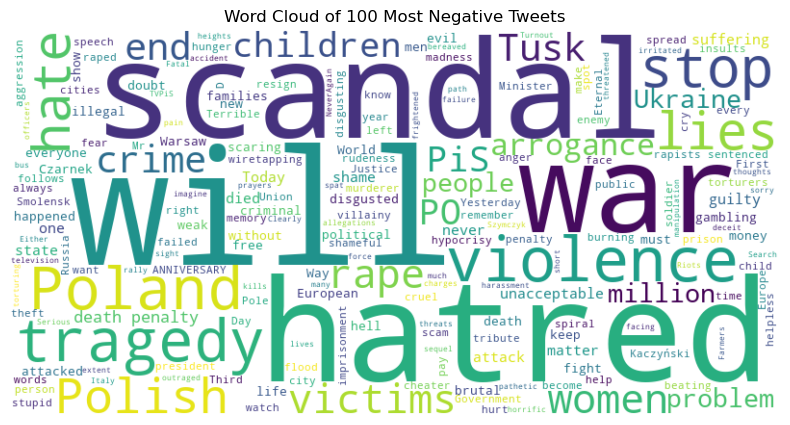

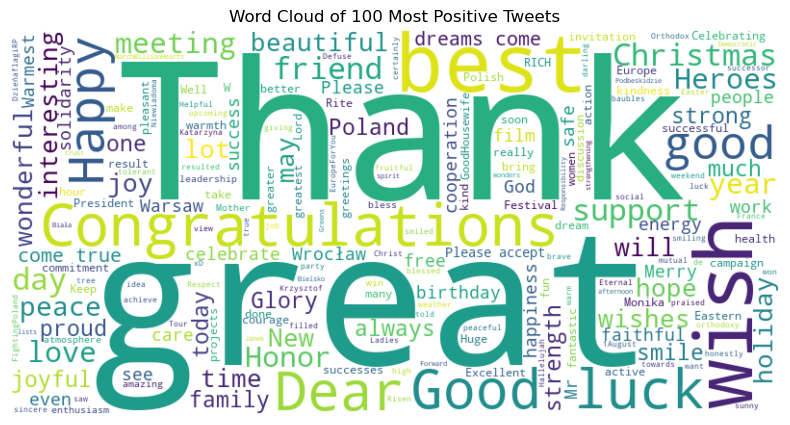

In [12]:
top_negative_posts = df_no_na.nlargest(100, 'neg_vader')[['name', 'party', 'text_clean_en', 'neg_vader']]
negative_texts = ' '.join(top_negative_posts['text_clean_en'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of 100 Most Negative Tweets')
plt.show()

top_positive_posts = df_no_na.nlargest(100, 'pos_vader')[['name', 'party', 'text_clean_en', 'pos_vader']]
negative_texts = ' '.join(top_positive_posts['text_clean_en'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of 100 Most Positive Tweets')
plt.show()

## 4. Supervised approach Sentiment Analysis (BERT)

In [22]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL, use_safetensors=True)

def bert_predict(text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    encoded_input = tokenizer(text, return_tensors='pt').to(device)
    with torch.no_grad():
        output = model(**encoded_input)
    scores = output[0][0].cpu().numpy()
    scores = softmax(scores)
    return scores

df_for_bert['text_bert'] = df_for_bert['text_clean_en_demojized'].apply(preprocess)
df_for_bert[['negative_bert', 'neutral_bert', 'positive_bert']] = df_for_bert['text_bert'].apply(lambda x: pd.Series(bert_predict(x), index=['negative', 'neutral', 'positive']))
df_for_bert[["username", "name", "text_clean_en", "negative_bert", "neutral_bert", "positive_bert"]].head()

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,username,name,text_clean_en,negative_bert,neutral_bert,positive_bert
0,placzekgrzegorz,Grzegorz Płaczek,"❌ The Polish government intends to build 49 Foreigners Integration Centers in Poland as a remedy for migrants, of whom there may be as many as 250,000 in Poland. – not to mention the thousands that Poland will accept in the coming years. And if someone says they won't accept it, they're LYING. ➡️…",0.172606,0.754593,0.072801
1,placzekgrzegorz,Grzegorz Płaczek,"❌ The cesspool is breaking out and it's getting more and more interesting. More and more new facts are coming to light. Well, the guidelines for the operation of 49 Foreigners Integration Centers (CIC) provide for foreigners throughout Poland, among others... the employment of PERSONAL ASSISTANTS in offices,...",0.217877,0.632106,0.150017
2,placzekgrzegorz,Grzegorz Płaczek,"❌ I DON'T UNDERSTAND HOW YOU CAN HURT YOUR OWN NATION IN THIS WAY?! Dark times are coming for Poles. For years. And perhaps even longer than we think. The Honorable Prime Minister, opening the #RadaKrajowaKO party convention in Warsaw, announced a PROGRAM that is dangerous for Poles...",0.915348,0.079416,0.005237
3,placzekgrzegorz,Grzegorz Płaczek,"🆘 The pharmaceutical company GSK will pay over $2 billion in compensation for a drug that, instead of treating heartburn, increased the risk of cancer! ➡️ Greetings to all big pharma lobbyists, ""sellout"" experts and scientists and corrupt politicians. Greetings also...",0.818385,0.161701,0.019913
4,placzekgrzegorz,Grzegorz Płaczek,"❌ WHAT IS GOING ON HERE? In October 2024, her boss, the Minister of Health, announced that the National Health Fund needed approximately PLN 3 billion from the state budget to pay hospitals for the next quarter of overperformance, adding that ""THIS MONEY DOES NOT EXIST"", while... ➡️…",0.569279,0.408524,0.022197


In [23]:
df_for_bert.to_parquet('../data/03.cleaned/df_bert_values_GIT.parquet', index=False)

### 4.1. Top 5 most negative politicians

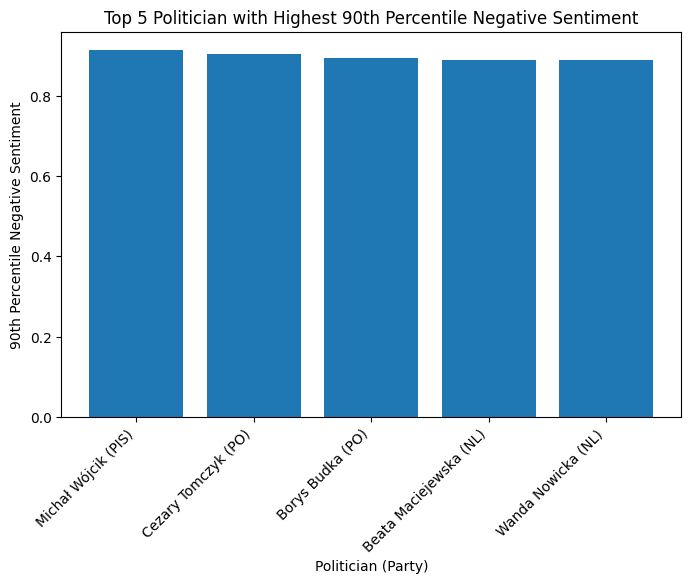

In [12]:
percentile_90_neg = df_for_bert.groupby('username')['negative_bert'].quantile(0.90).reset_index()

top5_neg_sentiment = percentile_90_neg.sort_values(by='negative_bert', ascending=False).head(5)
top5_neg_sentiment = top5_neg_sentiment.merge(df[['username', 'name', 'party']].drop_duplicates(), on='username', how='left')

plt.figure(figsize=(8, 5))
top5_neg_sentiment['name_with_party'] = top5_neg_sentiment['name'].apply(
    lambda name: f"{name} ({df[df['name'] == name]['party'].iloc[0]})"
)
bars = plt.bar(top5_neg_sentiment['name_with_party'], top5_neg_sentiment["negative_bert"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Top 5 Politician with Highest 90th Percentile Negative Sentiment')
plt.xlabel('Politician (Party)')
plt.ylabel('90th Percentile Negative Sentiment')
plt.show()

We can observe that the 90th percentile Negative Sentiment scores are quite comparable among the top 5 politicians. In comparison to VADER three politicians remain the same, while two have changed. This indicates a difference in predictions made by the VADER and BERT models.

### 4.2. Top 5 most positive politicians

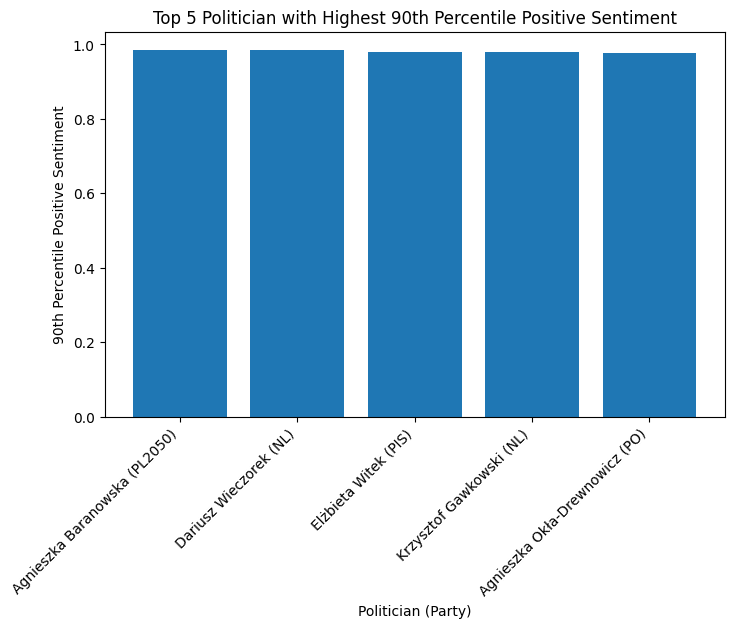

In [13]:
percentile_90_pos = df_for_bert.groupby('username')['positive_bert'].quantile(0.90).reset_index()

top5_pos_sentiment = percentile_90_pos.sort_values(by='positive_bert', ascending=False).head(5)
top5_pos_sentiment = top5_pos_sentiment.merge(df[['username', 'name', 'party']].drop_duplicates(), on='username', how='left')

plt.figure(figsize=(8, 5))
top5_pos_sentiment['name_with_party'] = top5_pos_sentiment['name'].apply(
    lambda name: f"{name} ({df[df['name'] == name]['party'].iloc[0]})"
)
bars = plt.bar(top5_pos_sentiment['name_with_party'], top5_pos_sentiment["positive_bert"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Top 5 Politician with Highest 90th Percentile Positive Sentiment')
plt.xlabel('Politician (Party)')
plt.ylabel('90th Percentile Positive Sentiment')
plt.show()

We can observe that the 90th percentile Positive Sentiment scores are quite comparable among the top 5 politicians. Compared to the VADER method, there are significant changes; only one politician stays the same.

### 5.3. Negative Sentiment on party level

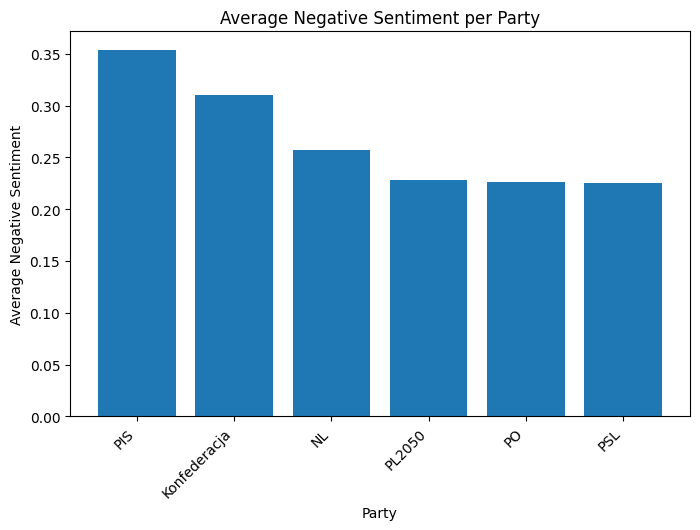

In [14]:
average_neg_sentiment_party = df_for_bert.groupby('party')['negative_bert'].mean().reset_index()

top5_avg_neg_sentiment_party = average_neg_sentiment_party.sort_values(by='negative_bert', ascending=False)

plt.figure(figsize=(8, 5))
bars = plt.bar(top5_avg_neg_sentiment_party['party'], top5_avg_neg_sentiment_party["negative_bert"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Average Negative Sentiment per Party')
plt.xlabel('Party')
plt.ylabel('Average Negative Sentiment')
plt.show()


We can observe that the party ranking is the same to this one obtained using the VADER method.

### 4.4. Positive Sentiment on party level

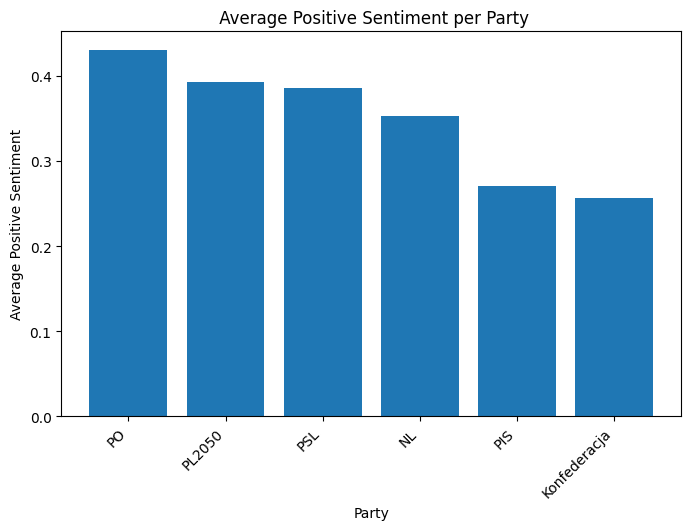

In [15]:
average_pos_sentiment_party = df_for_bert.groupby('party')['positive_bert'].mean().reset_index()

top5_avg_pos_sentiment_party = average_pos_sentiment_party.sort_values(by='positive_bert', ascending=False)

plt.figure(figsize=(8, 5))
bars = plt.bar(top5_avg_pos_sentiment_party['party'], top5_avg_pos_sentiment_party["positive_bert"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title(' Average Positive Sentiment per Party')
plt.xlabel('Party')
plt.ylabel('Average Positive Sentiment')
plt.show()


In comparison to VADER, the first two positions remain unchanged, while the parties ranked third and fourth, as well as fifth and sixth, switch places.

### 4.5. Most Negative Tweets 

In [16]:
top_5_negative_tweets = df_for_bert.nlargest(10, 'negative_bert')[['name', 'party', 'text_clean_en', 'negative_bert']]
print("Top 5 Most Negative Tweets:")
print(top_5_negative_tweets)

Top 5 Most Negative Tweets:
                            name         party  \
26279              Michał Wójcik           PIS   
16941               Tomasz Trela            NL   
33342          Marcin Kierwiński            PO   
18891   Anita Kucharska-Dziedzic            NL   
16087               Tomasz Trela            NL   
23249             Robert Biedroń            NL   
47005  Władysław Kosiniak-Kamysz           PSL   
5399            Sławomir Mentzen  Konfederacja   
35512           Dorota Niedziela            PO   
4002            Marek Sypniewski  Konfederacja   

                                           text_clean_en  negative_bert  
26279  The economy is sinking, the judiciary is sinki...       0.964357  
16941  "This is shit that has been stinking since the...       0.958812  
33342  Apparently tomorrow there will be another act ...       0.958261  
18891  #Measles is dying and will continue to die bec...       0.957150  
16087    Oh Mateusz liar, you have done nothing but

The RoBERTa model is able to identify more sophisticated negative tweets. Unlike VADER, which often predicts that the most negative tweets are single negative words, RoBERTa captures the nuanced meaning of the tweets. There is no need to filter out short tweets with only one word (e.g., "NO") as was necessary with VADER. These tweets are mostly critical of the actions of other parties, with the majority coming from NL but also from PO, Konfederacja, PiS and PSL.

### 4.6. Most Positive Tweets 

In [17]:
top_5_positive_tweets = df_for_bert.nlargest(10, 'positive_bert')[['name', 'party', 'text_clean_en', 'positive_bert']]
print("Top 5 Most Positive Tweets:")
print(top_5_positive_tweets)

Top 5 Most Positive Tweets:
                            name   party  \
13016          Krzysztof Śmiszek      NL   
31561                 Ewa Kopacz      PO   
45588  Władysław Kosiniak-Kamysz     PSL   
30767             Cezary Tomczyk      PO   
37692  Małgorzata Kidawa-Błońska      PO   
16543               Tomasz Trela      NL   
40714                 Paweł Śliz  PL2050   
46042           Piotr Zgorzelski     PSL   
38555  Agnieszka Okła-Drewnowicz      PO   
39098          Rafał Trzaskowski      PO   

                                           text_clean_en  positive_bert  
13016  What beautiful news! Good luck and I hope to s...       0.991244  
31561  A beautiful day and great hope that the dreams...       0.991093  
45588  It's going to be a good day. It's time for a h...       0.990978  
30767  Today is his birthday! Happy birthday Marcin! ...       0.990956  
37692  Happy birthday, darling! Always be smiling, br...       0.990776  
16543  Best among friends. A fantastic meet

The most positive tweets from the RoBERTa model are more meaningful than those from the VADER method. They are notably longer and often reflect the authors' happiness following certain events, such as meetings with voters or positive election results.

### 5.7. Word clouds

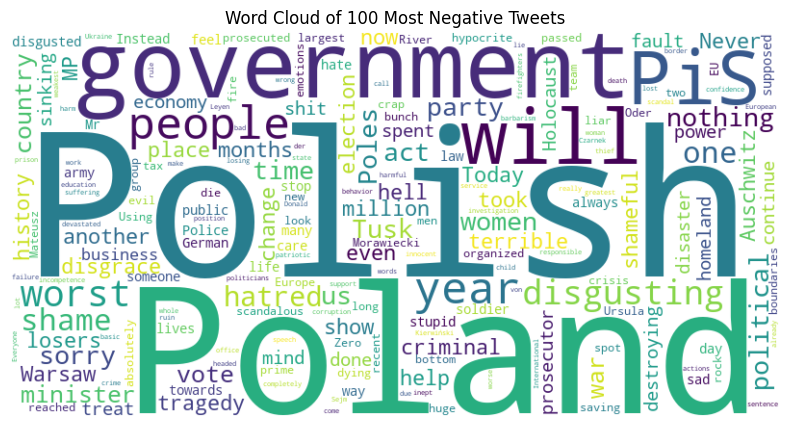

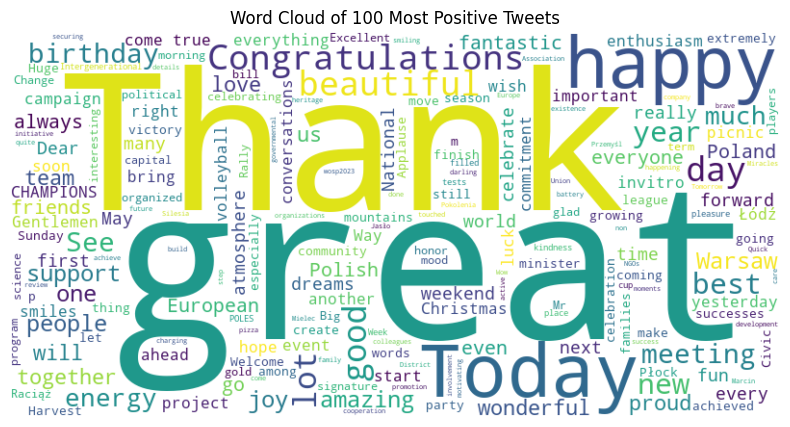

In [18]:
top_negative_posts = df_for_bert.nlargest(100, 'negative_bert')[['name', 'party', 'text_clean_en', 'negative_bert']]
negative_texts = ' '.join(top_negative_posts['text_clean_en'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of 100 Most Negative Tweets')
plt.show()

top_positive_posts = df_for_bert.nlargest(100, 'positive_bert')[['name', 'party', 'text_clean_en', 'positive_bert']]
negative_texts = ' '.join(top_positive_posts['text_clean_en'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of 100 Most Positive Tweets')
plt.show()

## 5. Conclusions

1. The RoBERTa model is able to identify more sophisticated negative tweets compared to VADER. While VADER often predicts that the most negative tweets are single negative words, RoBERTa captures the nuanced meaning of the tweets. There is no need to filter out short tweets with only one word (e.g., "NO") as was necessary with VADER. These tweets are mostly critical of the actions of other parties, with the majority coming from PIS.

2. The most positive tweets identified by the RoBERTa model are more meaningful than those from the VADER method. They are notably longer and often reflect the authors' happiness following certain events, such as meetings with voters or positive election results.

3. According to the VADER analysis, the top 5 politicians with the highest 90th percentile of negative sentiment in their tweets include 2 individuals from NL and 1 from PO, PiS and Konfederacja. In contrast, the RoBERTa model also includes 2 politicians from NL and PO and 1 from PiS. This indicates a difference in predictions made by the VADER and BERT models. 

4. The 90th percentile Positive Sentiment scores are quite comparable among the top 5 politicians. However, there are significant changes when comparing the VADER method to the RoBERTa model. Only one politician stay the same. This discrepancy may be due to the similarity of scores, which can lead to shifts in ranking, especially among closely positioned candidates.

5. The party rankings for negative sentiment are similar between the VADER and RoBERTa methods.

6. The party rankings for average positive sentiment are also very similar between VADER and RoBERTa. The top two parties remain the same in both methods, while the parties ranked third and fourth, as well as fifth and sixth, switch places. 

7. RoBERTa model is harder to interpret because it does not assign pure weights to each word as VADER does. However, it can better detect the most positive and negative tweets, making them more meaningful and truly expressive of positive or negative emotions.

## 6. Refrences

[1] Hutto, C., & Gilbert, E. (2014). VADER: A Parsimonious Rule-Based Model for Sentiment Analysis of Social Media Text. Proceedings of the International AAAI Conference on Web and Social Media, 8(1), 216–225. https://doi.org/10.1609/icwsm.v8i1.14550

[2] Yinhan Liu, Myle Ott, Naman Goyal, Jingfei Du, Mandar Joshi, Danqi Chen, Omer Levy, Mike Lewis, Luke Zettlemoyer, and Veselin Stoyanov. 2019. Roberta: A robustly optimized bert pretraining approach. arXiv preprint arXiv:190711692.
